# Model Explanation

## Dataset & Model Loading

In [2]:
import pandas as pd
import numpy as np
import joblib
import random
import matplotlib.pyplot as plt
from treeinterpreter import treeinterpreter as ti
from IPython.display import display
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from utils.text_preprocessing import preprocess_text

df_train = pd.read_csv("../dataset/training_set.csv")
df_train["text"] = df_train["text"].apply(preprocess_text)
df_voc = df_train[df_train["multiclass_label"] != "not_cyberbullying"].copy()
label2id = {label: idx for idx, label in enumerate(sorted(df_voc["multiclass_label"].unique()))}

df_filtered = pd.read_csv("../dataset/true_positive.csv")
df_filtered["label_id"] = df_filtered["multiclass_label"].map(label2id)
X_text = df_filtered["text"]
y_multiclass = df_filtered["label_id"]

tfidf_vectorizer = joblib.load("../model/tfidf_vocabulary_multiclass.pkl")
X_test_tfidf = tfidf_vectorizer.transform(X_text)

file_name1 = f"../model/grid_search_multiclass/RandomForest_TF-IDF_multiclass.pkl"
clf = joblib.load(file_name1)

print(type(clf))
print(clf.steps)

# from <class 'sklearn.pipeline.Pipeline'> extract <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
rf_model = clf.named_steps["model"] 

print(type(rf_model))

file_name2 = f"../model/grid_search_binary_f1/RandomForest_TF-IDF.pkl"
clf2 = joblib.load(file_name2)

print(type(clf2))
print(clf2.steps)

# from <class 'sklearn.pipeline.Pipeline'> extract <class 'sklearn.ensemble._forest.RandomForestClassifier'> 
rf_binary = clf.named_steps["model"] 

print(type(rf_binary))


<class 'sklearn.pipeline.Pipeline'>
[('model', RandomForestClassifier(n_estimators=1000, random_state=42))]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.pipeline.Pipeline'>
[('model', RandomForestClassifier(class_weight='balanced', n_estimators=1000,
                       random_state=42))]
<class 'sklearn.ensemble._forest.RandomForestClassifier'>


## Random Example Selection

In [3]:
# Imposta seme di riproducibilità
random.seed(42)
np.random.seed(42)

# 1. Carica il test set originale
df_test = pd.read_csv("../dataset/test_set.csv")  # se hai un altro test set, cambia il path
df_test = df_test[df_test["multiclass_label"] != "not_cyberbullying"].copy()

# 2. Salva il testo originale prima del preprocessing
df_test["original_text"] = df_test["text"]

# 3. Preprocessing
df_test["text"] = df_test["text"].apply(preprocess_text)

# 4. Filtro: mantieni solo i testi presenti nei true positive
X_text_set = set(X_text)  # X_text è la colonna preprocessata di true_positive.csv
df_test = df_test[df_test["text"].isin(X_text_set)].copy()

# 5. Mappa le label
df_test["label_id"] = df_test["multiclass_label"].map(label2id)

# 6. Trasforma i testi in vettori TF-IDF e classifica
X_tfidf_test = tfidf_vectorizer.transform(df_test["text"])
y_pred = rf_model.predict(X_tfidf_test)

# 7. Confronta con le etichette reali
df_test["y_pred"] = y_pred
df_test["correct"] = df_test["label_id"] == df_test["y_pred"]

# 8. Seleziona esattamente 5 esempi corretti per ciascuna classe
data = []
for label_id in df_test["label_id"].unique():
    df_label = df_test[(df_test["label_id"] == label_id) & (df_test["correct"])]
    
    if len(df_label) >= 5:
        selected = df_label.sample(5, random_state=42)
    elif len(df_label) > 0:
        selected = df_label.sample(5, replace=True, random_state=42)
    else:
        continue  # Nessun esempio corretto per questa classe

    for i, (_, row) in enumerate(selected.iterrows(), 1):
        data.append({
            "label_id": label_id,
            "label_name": row["multiclass_label"],
            "text": row["text"],  # preprocessato
            "original_text": row["original_text"],
            "original_index": row.name,
            "example_num": i
        })

# 9. Costruisci DataFrame e salva
df_correct_examples = pd.DataFrame(data)
df_correct_examples.sort_values(by=["label_name", "example_num"], inplace=True)

selected_rows = [0, 5, 12, 17, 21]
df_expl_samples_subset = df_correct_examples.iloc[selected_rows].reset_index(drop=True)


print(df_expl_samples_subset)
df_expl_samples_subset.to_csv("../dataset/selected_explanable_example.csv", index=False)


   label_id           label_name  \
0         0                  age   
1         1            ethnicity   
2         2               gender   
3         3  other_cyberbullying   
4         4             religion   

                                                text  \
0  imagin everi stan everi platform went school t...   
1  wonder unemploy english major feel dumb fuck l...   
2      gay nigga couldnt wait act like bitch tonight   
3  twitter search name set fire see give two shit...   
4           muslim land ever live anyth tyrant dummi   

                                       original_text  original_index  \
0  imagine if every stan on every platform went t...             175   
1  I wonder how unemployed English majors feel ab...            9248   
2  &#128514;&#128514;&#128514;&#128514;&#128514;&...             348   
3  .@jlorry96 twitter search for my name and "set...            3140   
4  @98Halima @johnnygjokaj @rfrankh53 @BilalIGhum...            7186   

   example_nu

## Local Model Explanation

In [4]:
pd.set_option("display.max_rows", 400)
pd.set_option("display.max_columns", 0)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.expand_frame_repr", False)

df_correct_examples = pd.read_csv("../dataset/selected_explanable_example.csv")

# Trasforma direttamente i testi salvati nel CSV
X_example_tfidf = tfidf_vectorizer.transform(df_correct_examples["text"]).toarray().astype("float32")
feature_names = tfidf_vectorizer.get_feature_names_out() 

for i in range(len(df_correct_examples)):
    label_id = df_correct_examples.loc[i, "label_id"]
    label_name = df_correct_examples.loc[i, "label_name"]
    text = df_correct_examples.loc[i, "text"]
    
    x = X_example_tfidf[i].reshape(1, -1)

    prediction, bias, contributions = ti.predict(rf_model, x)
    predicted_label_id = np.argmax(prediction)

    data = []
    for j in range(len(feature_names)):
        data.append({
            "feature": feature_names[j],
            "contribution": contributions[0][j][predicted_label_id], 
            "tfidf_value": x[0][j]
        })

    df_interp = pd.DataFrame(data)
    df_interp_sorted = df_interp.reindex(df_interp.contribution.abs().sort_values(ascending=False).index)

    print(f"\n=== TreeInterpreter Explanation ===")
    print(f"True class: {label_id} ({label_name})")
    print(f"Predicted class: {predicted_label_id}")
    print(f"Text preview: {text[:150]}...\n")
    print(f"Bias (expected value): {bias[0][predicted_label_id]:.4f}")
    print(f"Prediction (probabilities): {prediction[0]}")
    
    display(df_interp_sorted.head(25))
    print("=" * 100)



=== TreeInterpreter Explanation ===
True class: 0 (age)
Predicted class: 0
Text preview: imagin everi stan everi platform went school togetherid bulli wevers vlive tiktok stan...

Bias (expected value): 0.2023
Prediction (probabilities): [0.995 0.    0.002 0.003 0.   ]


,feature,contribution,tfidf_value
256,school,0.477878,0.224285
36,bulli,0.291441,0.213911
124,high,-0.048100,0.000000
101,girl,-0.031903,0.000000
329,went,0.015602,0.470862
205,nigger,0.008266,0.000000
194,muslim,0.006830,0.000000
69,dumb,0.006551,0.000000
187,middl,-0.005885,0.000000
95,fuck,0.005614,0.000000



=== TreeInterpreter Explanation ===
True class: 1 (ethnicity)
Predicted class: 1
Text preview: wonder unemploy english major feel dumb fuck like chief keef make million ignor nigger...

Bias (expected value): 0.2016
Prediction (probabilities): [0.    0.996 0.001 0.002 0.001]


,feature,contribution,tfidf_value
205,nigger,0.303744,0.298217
69,dumb,0.284248,0.302382
95,fuck,0.158114,0.276799
36,bulli,0.014085,0.000000
256,school,0.012855,0.000000
20,ass,-0.010715,0.000000
33,black,-0.007300,0.000000
135,ignor,0.006761,0.531042
242,rape,0.006751,0.000000
177,make,-0.006585,0.370392



=== TreeInterpreter Explanation ===
True class: 2 (gender)
Predicted class: 2
Text preview: gay nigga couldnt wait act like bitch tonight...

Bias (expected value): 0.2011
Prediction (probabilities): [0.029 0.39  0.469 0.053 0.059]


,feature,contribution,tfidf_value
99,gay,0.257072,0.292319
32,bitch,0.191282,0.343689
204,nigga,-0.114168,0.469304
242,rape,-0.107550,0.000000
149,joke,-0.097681,0.000000
87,femal,-0.048511,0.000000
37,call,-0.036298,0.000000
256,school,0.030776,0.000000
36,bulli,0.030769,0.000000
205,nigger,0.025942,0.000000



=== TreeInterpreter Explanation ===
True class: 3 (other_cyberbullying)
Predicted class: 3
Text preview: twitter search name set fire see give two shit think...

Bias (expected value): 0.1925
Prediction (probabilities): [0.02666905 0.014      0.31277917 0.63255179 0.014     ]


,feature,contribution,tfidf_value
310,two,-0.222358,0.441207
256,school,0.042291,0.000000
309,twitter,0.039496,0.422359
194,muslim,0.039103,0.000000
69,dumb,0.024733,0.000000
142,islam,0.024712,0.000000
205,nigger,0.024547,0.000000
149,joke,0.022182,0.000000
242,rape,0.021082,0.000000
298,think,-0.020540,0.309965



=== TreeInterpreter Explanation ===
True class: 4 (religion)
Predicted class: 4
Text preview: muslim land ever live anyth tyrant dummi...

Bias (expected value): 0.2026
Prediction (probabilities): [0.001 0.027 0.05  0.094 0.828]


,feature,contribution,tfidf_value
194,muslim,0.672587,0.367154
134,idiot,-0.050863,0.000000
75,ever,-0.037947,0.561219
16,anyth,-0.030728,0.506013
142,islam,-0.023722,0.000000
36,bulli,0.022263,0.000000
256,school,0.017487,0.000000
44,christian,-0.016863,0.000000
168,live,0.014896,0.542386
218,past,0.014416,0.000000


## Global Model Explanation

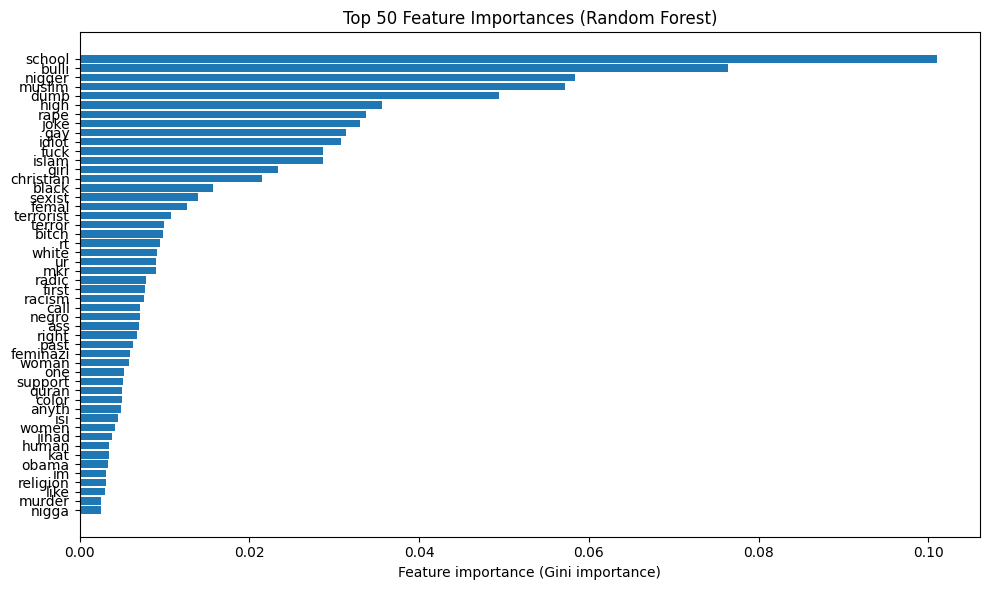

In [5]:
importances = rf_model.feature_importances_

feature_names = tfidf_vectorizer.get_feature_names_out()

df_importances = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top_k = 50
df_top = df_importances.head(top_k)

plt.figure(figsize=(10, 6))
plt.barh(df_top["feature"][::-1], df_top["importance"][::-1])
plt.xlabel("Feature importance (Gini importance)")
plt.title("Top 50 Feature Importances (Random Forest)")
plt.tight_layout()
plt.show()


